<a href="https://colab.research.google.com/github/Kimsumin1234/textmining/blob/main/04_%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81_%EC%97%B0%ED%95%A9%EB%89%B4%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 토픽모델링
  - 1. LDA 토픽모델링
  - 2. NMF 토픽모델링

In [1]:
!pip install koreanize_matplotlib

!apt -qq -y install fonts-nanum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 7.4 MB/s eta 0:00:00
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import matplotlib.font_manager as fm

import warnings
warnings.filterwarnings("ignore")

In [3]:
for fpath in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
  fm.fontManager.addfont(fpath)


plt.rc("font",family='NanumBarunGothic')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation

In [6]:
url = "https://raw.githubusercontent.com/KLUE-benchmark/KLUE/main/klue_benchmark/ynat-v1.1/ynat-v1.1_train.json"

df = pd.read_json(url)[['title','label']]
df.head(2)

,title,label
0,유튜브 내달 2일까지 크리에이터 지원 공간 운영,생활문화
1,어버이날 맑다가 흐려져…남부지방 옅은 황사,생활문화


In [7]:
df.shape

(45678, 2)

In [8]:
df['label'].unique().tolist()

['생활문화', '사회', 'IT과학', '스포츠', '세계', '정치', '경제']

In [9]:
# 토픽별로 학습을 시키기 때문에 토픽별 비중이 고르게 분포되있는것도 중요하다

df['label'].value_counts()

label
세계      8320
스포츠     7742
정치      7379
경제      6118
생활문화    5751
IT과학    5235
사회      5133
Name: count, dtype: int64

In [10]:
df['label'].value_counts(normalize=True)

label
세계      0.182145
스포츠     0.169491
정치      0.161544
경제      0.133938
생활문화    0.125903
IT과학    0.114607
사회      0.112374
Name: proportion, dtype: float64

### TfidfVectorizer 벡터화

In [11]:
# 객체 생성
# max_features=10000 : 1만개 단어만 높은순으로 추출

tfidfvect = TfidfVectorizer(max_features=10000)
tfidfvect

TfidfVectorizer(max_features=10000)

In [12]:
dtm = tfidfvect.fit_transform(df['title'])
dtm

<45678x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 207106 stored elements in Compressed Sparse Row format>

In [13]:
df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidfvect.get_feature_names_out())
df_dtm.head()

,00,01,02,03,0원,10,100,1004,100gb,100개,...,히어로즈,힐러리,힐러리트럼프,힐링,힐만,힘든,힘으로,힘은,힘찬,女배구
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: title={'center': '연합뉴스 TF-IDF 가중치'}>

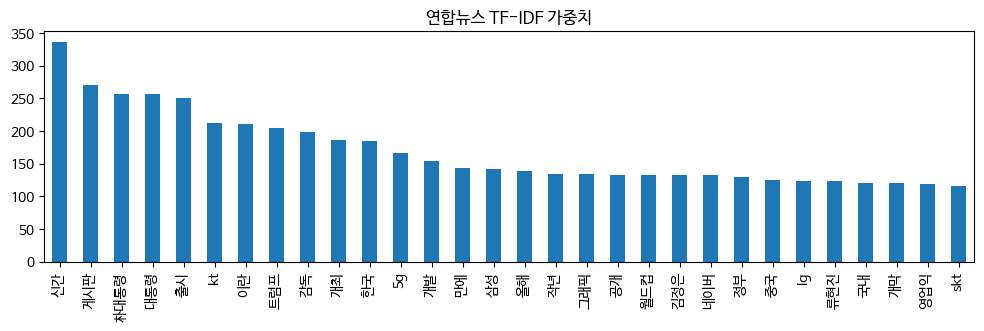

In [14]:
# 가중치합계가 큰순으로 30개만 추출해서 차트 그려보기

df_dtm.sum().nlargest(30).plot(kind='bar',figsize=(12,3),title='연합뉴스 TF-IDF 가중치')

In [15]:
# n_components=7 : 토픽이 7개
df['label'].unique().tolist()

['생활문화', '사회', 'IT과학', '스포츠', '세계', '정치', '경제']

- W : 원본문서와 토픽의 조합을 표현한 행렬

In [16]:
LDA_model = LatentDirichletAllocation(n_components=7, random_state=42)
W = LDA_model.fit_transform(df_dtm)
W.shape

(45678, 7)

- H : n_components(토픽의 수) 에 지정된 행 의 수를 가지며, 원본 문서의 dtm 의 열 과 동일한 수의 열을 가짐

In [17]:
H = LDA_model.components_
H.shape

(7, 10000)

In [18]:
df_lda_w = pd.DataFrame(W)
df_lda_w.head()

,0,1,2,3,4,5,6
0,0.041950,0.041873,0.041986,0.748684,0.041841,0.041841,0.041825
1,0.714063,0.047656,0.047656,0.047656,0.047656,0.047656,0.047656
2,0.404953,0.047719,0.047681,0.047753,0.047681,0.356511,0.047701
3,0.044408,0.044764,0.044750,0.044399,0.577605,0.044455,0.199619
4,0.052451,0.052419,0.685187,0.052637,0.052419,0.052419,0.052468


In [19]:
df['label'].unique().tolist()

['생활문화', '사회', 'IT과학', '스포츠', '세계', '정치', '경제']

In [20]:
df_lda_w['title'] = df['title']
df_lda_w['label'] = df['label']
df_lda_w.head(15).style.background_gradient(axis=1)

,0,1,2,3,4,5,6,title,label
0,0.041950,0.041873,0.041986,0.748684,0.041841,0.041841,0.041825,유튜브 내달 2일까지 크리에이터 지원 공간 운영,생활문화
1,0.714063,0.047656,0.047656,0.047656,0.047656,0.047656,0.047656,어버이날 맑다가 흐려져…남부지방 옅은 황사,생활문화
2,0.404953,0.047719,0.047681,0.047753,0.047681,0.356511,0.047701,내년부터 국가RD 평가 때 논문건수는 반영 않는다,사회
3,0.044408,0.044764,0.044750,0.044399,0.577605,0.044455,0.199619,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,사회
4,0.052451,0.052419,0.685187,0.052637,0.052419,0.052419,0.052468,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,생활문화
5,0.712947,0.047802,0.047928,0.048031,0.047771,0.047731,0.047790,야외서 생방송 하세요…액션캠 전용 요금제 잇따라,IT과학
6,0.052727,0.052729,0.052741,0.052727,0.052731,0.052734,0.683613,월드컵 태극전사 16강 전초기지 레오강 입성종합,스포츠
7,0.643871,0.059427,0.059339,0.059339,0.059339,0.059346,0.059339,미세먼지 속 출근길,생활문화
8,0.052383,0.685591,0.052383,0.052494,0.052383,0.052383,0.052383,왓츠앱稅 230원에 성난 레바논 민심…총리사퇴로 이어져종합2보,세계
9,0.037702,0.037677,0.089258,0.037715,0.038048,0.721966,0.037634,베트남 경제 고성장 지속…2분기 GDP 6.71% 성장,세계


In [21]:
# 인덱스 : 토픽

df_lda_topic = pd.DataFrame(H, columns=tfidfvect.get_feature_names_out())
df_lda_topic

,00,01,02,03,0원,10,100,1004,100gb,100개,...,히어로즈,힐러리,힐러리트럼프,힐링,힐만,힘든,힘으로,힘은,힘찬,女배구
0,0.142863,0.143075,0.142858,0.142858,2.397399,9.529675,0.144217,1.507782,2.568095,0.142990,...,0.146355,0.143102,0.142888,0.142994,0.142858,0.143022,0.142858,0.142858,0.143037,0.145299
1,0.142865,0.142858,0.142892,5.374504,0.143517,2.968749,0.492713,0.142858,0.142858,0.143862,...,0.314599,23.674168,0.142886,3.756892,0.142885,0.142912,0.142858,0.791872,0.143437,4.595844
2,0.143018,0.142858,0.142858,0.142901,0.142859,0.143182,6.270921,0.142858,0.142858,0.142902,...,0.142858,0.143048,0.142867,0.142858,0.142902,0.142970,1.332518,0.142858,2.978050,0.169716
3,0.142914,0.142872,0.142887,0.142858,0.142893,5.529132,0.143087,0.142950,0.143669,0.142858,...,1.974718,0.665782,2.764685,0.142990,0.142863,0.143050,0.142933,0.143013,0.142976,0.142858
4,0.142882,2.078855,0.617406,0.143067,0.143719,10.245513,4.162505,0.142858,0.142858,0.142938,...,0.142930,7.633259,0.853295,0.142858,0.142858,0.142912,2.014340,3.097541,0.142858,0.142858
5,0.142923,0.142869,0.142902,0.142858,0.674504,13.157550,2.451659,0.142858,0.142876,0.622857,...,0.142923,12.473975,1.923603,0.142904,9.079115,0.143164,0.143711,0.142858,0.143798,0.143177
6,7.517126,4.500869,4.411950,0.143036,1.261634,7.167611,4.936983,1.798647,0.142891,2.718335,...,4.753069,0.153126,1.867547,0.142961,0.143665,4.318451,2.338100,0.142858,0.142858,6.880116


In [22]:
# 0 번 토픽을 기준으로 상위 키워드 30개

df_lda_topic.loc[0].nlargest(30)

개최      134.781501
이란      108.178633
5g       96.301521
kt       95.113949
게시판      89.236277
대통령      85.477764
전국       85.206218
특징주      63.447956
개막       60.778065
2018     59.907959
이스라엘     57.114941
미세먼지     55.328574
날씨       49.400799
사우디      48.200323
최고       44.349431
서울       43.185441
어떻게      43.145120
출시       43.132973
개발       39.487348
행사       39.301583
기술       36.935021
대구       36.581520
충북       35.420340
공격       34.902537
판매       34.058139
상장       32.185186
내달       31.870583
내일       31.685539
미래부      31.671372
핵합의      30.723316
Name: 0, dtype: float64

In [23]:
# n_components=4 : n_topics=4

LDA_model = LatentDirichletAllocation(n_components=4, random_state=42)
W = LDA_model.fit_transform(df_dtm)
W.shape

(45678, 4)

In [24]:
H = LDA_model.components_
H.shape

(4, 10000)

In [25]:
df_lda_w = pd.DataFrame(W)

In [26]:
df_lda_w['title'] = df['title']
df_lda_w['label'] = df['label']
df_lda_w.head(15).style.background_gradient(axis=1)

,0,1,2,3,title,label
0,0.080404,0.074749,0.074774,0.770073,유튜브 내달 2일까지 크리에이터 지원 공간 운영,생활문화
1,0.749750,0.083417,0.083417,0.083416,어버이날 맑다가 흐려져…남부지방 옅은 황사,생활문화
2,0.740820,0.089661,0.084038,0.085481,내년부터 국가RD 평가 때 논문건수는 반영 않는다,사회
3,0.079859,0.367688,0.474018,0.078434,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,사회
4,0.092281,0.094523,0.719789,0.093407,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,생활문화
5,0.740109,0.086521,0.088018,0.085353,야외서 생방송 하세요…액션캠 전용 요금제 잇따라,IT과학
6,0.092308,0.721797,0.093258,0.092637,월드컵 태극전사 16강 전초기지 레오강 입성종합,스포츠
7,0.688210,0.104093,0.103849,0.103848,미세먼지 속 출근길,생활문화
8,0.508610,0.095217,0.095259,0.300914,왓츠앱稅 230원에 성난 레바논 민심…총리사퇴로 이어져종합2보,세계
9,0.281955,0.068602,0.359064,0.290379,베트남 경제 고성장 지속…2분기 GDP 6.71% 성장,세계


In [27]:
df_lda_topic = pd.DataFrame(H, columns=tfidfvect.get_feature_names_out())
df_lda_topic

,00,01,02,03,0원,10,100,1004,100gb,100개,...,히어로즈,힐러리,힐러리트럼프,힐링,힐만,힘든,힘으로,힘은,힘찬,女배구
0,0.250258,0.252849,0.250164,0.250173,3.776987,22.964080,4.713724,3.270361,2.673886,0.262612,...,0.253662,0.688217,0.251897,0.255538,0.250766,0.252917,0.255196,0.252324,2.019792,0.255097
1,0.252886,6.525137,4.987244,5.474805,0.258325,7.409215,3.888970,0.250150,0.250135,0.253478,...,2.562597,17.623393,0.252237,3.856348,5.077844,0.262424,0.250819,3.846489,0.278241,11.409754
2,0.251672,0.257594,0.251719,0.255903,0.610731,8.923377,9.743113,0.250154,0.250860,3.286097,...,0.252812,14.072202,0.252020,0.250219,0.253122,0.253951,3.874850,0.250745,1.285864,0.251580
3,7.619774,0.258675,0.254626,0.251199,0.260483,9.444741,0.256280,0.250147,0.251222,0.254556,...,4.548382,12.502649,7.081619,0.252351,4.355415,4.407188,1.876453,0.254301,0.253117,0.303438


In [28]:
def plot_top_words(model, feature_names, n_top_words, title, n_topics=4):
  df_topic = pd.DataFrame(model.components_, columns=feature_names)

  fig,axes = plt.subplots(1,n_topics,figsize=(6 * n_topics, 15), sharex=True)
  axes = axes.flatten()

  for topic_idx in df_lda_topic.index:
    ax = axes[topic_idx]
    df_topic.loc[topic_idx].nlargest(n_top_words).plot.barh(ax=ax)
    ax.invert_yaxis()
    ax.set_title(f'Topic {topic_idx + 1}',fontdict={'fontsize':20})
    ax.tick_params(axis='both',which='major',labelsize=15)
    for i in 'top right'.split():
      ax.spines[i].set_visible(False)

  fig.suptitle(title,fontsize=30)
  plt.subplots_adjust(top=0.90,bottom=0.05,wspace=0.90,hspace=0.3)

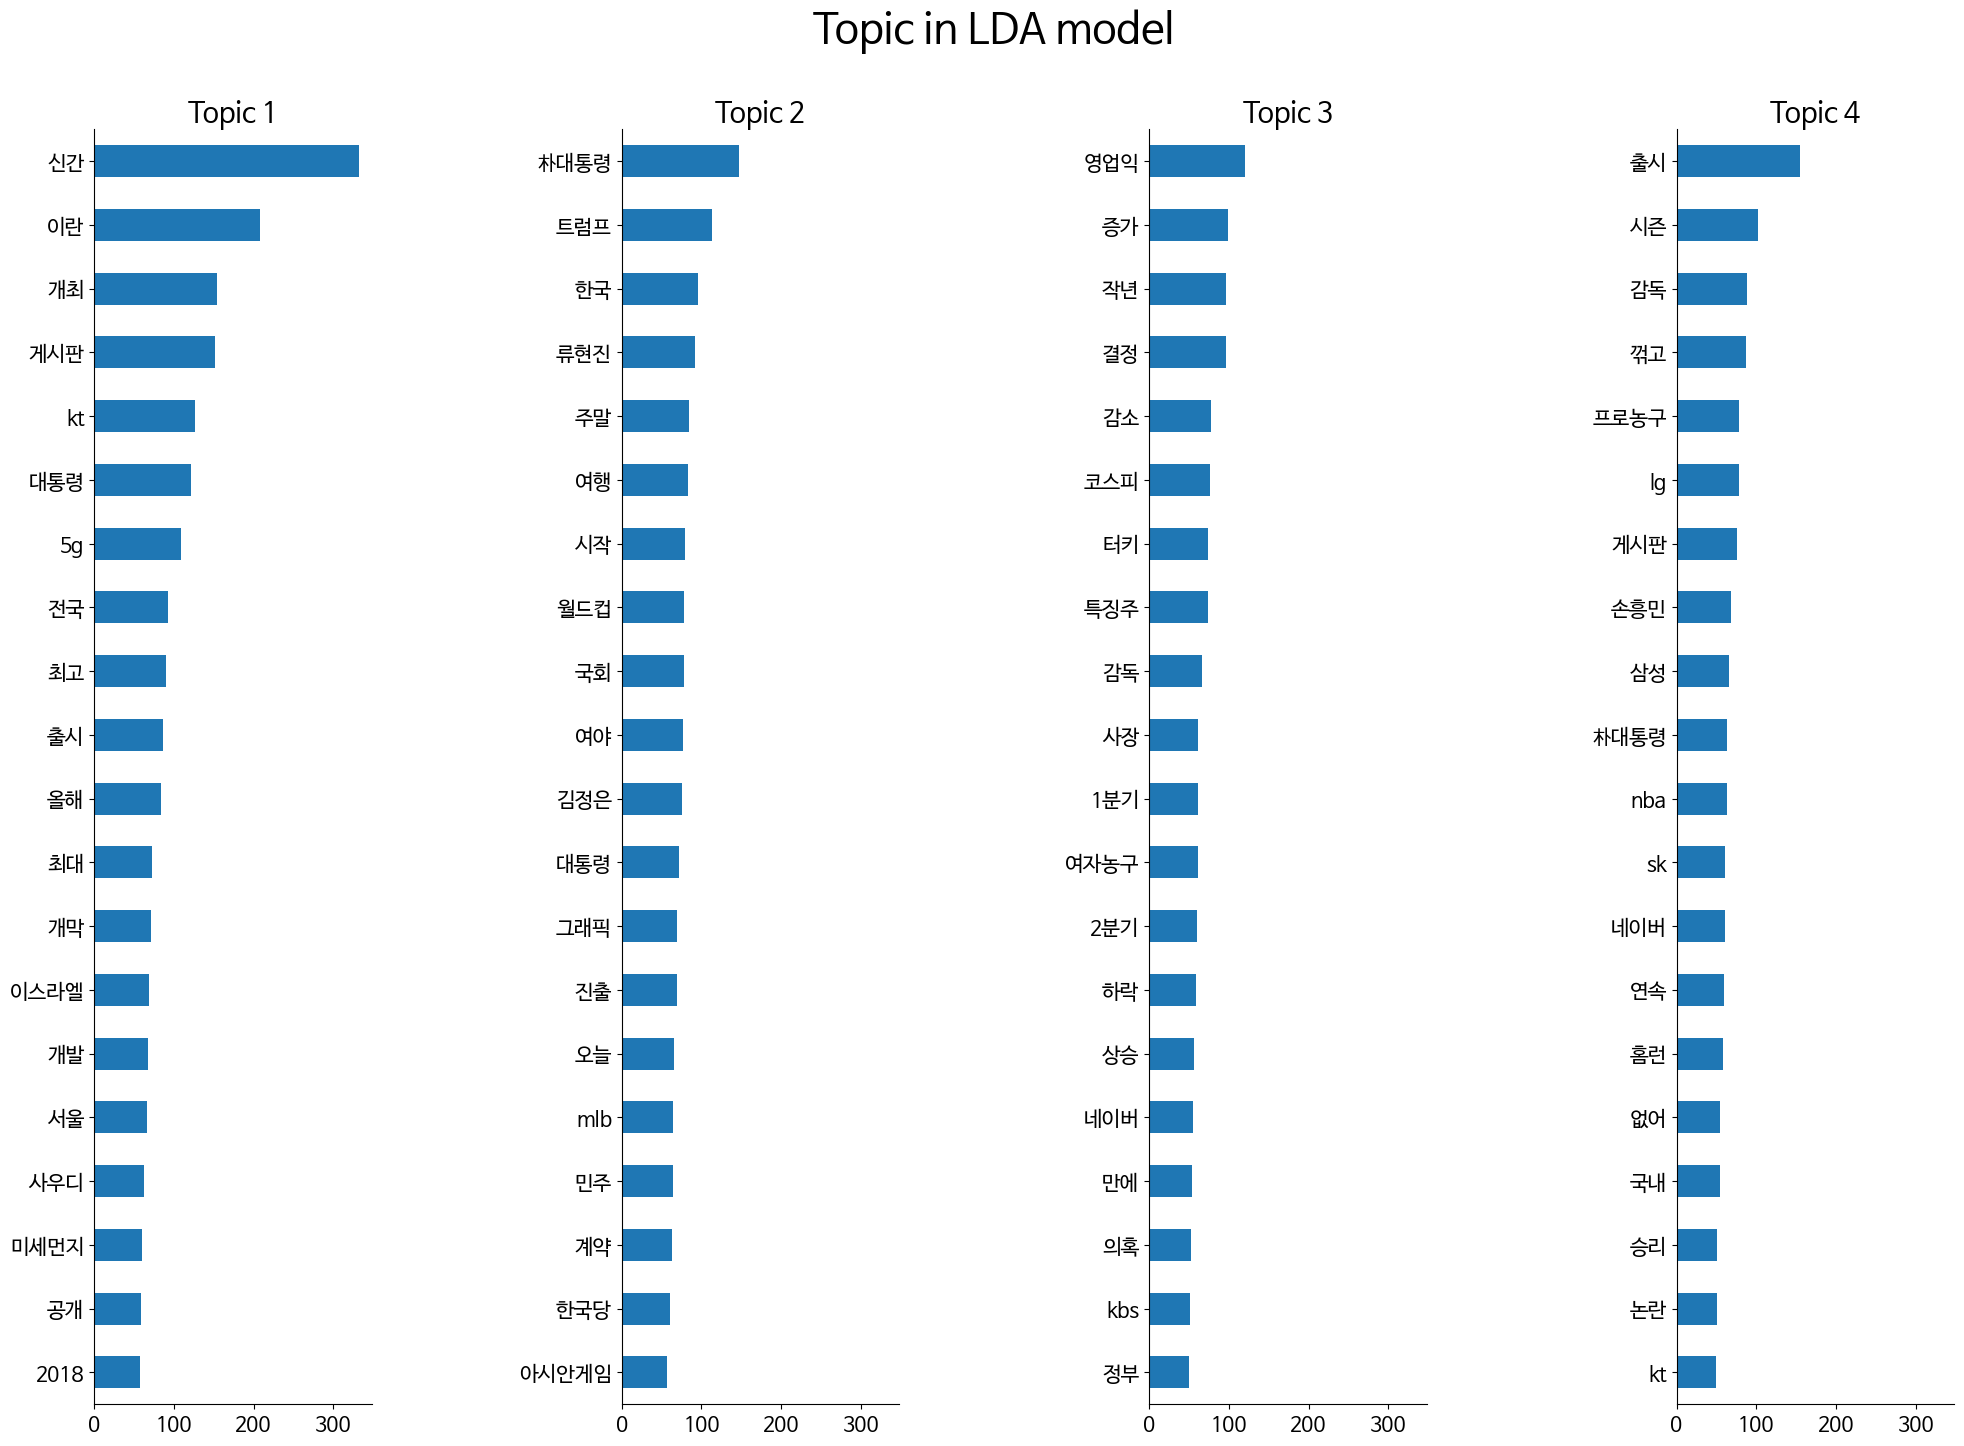

In [29]:
# n_components=4 : n_topics=4

n_top_words = 20
plot_top_words(LDA_model,tfidfvect.get_feature_names_out(), n_top_words, 'Topic in LDA model')

### NMF (Non Negative Matrix Factorization) 토픽 모델링
- 행렬 분해 기법을 사용한다

In [30]:
# W : 원본 데이터 X(df_dtm) 의 각 행이 어떻게 H 의 각 행(또는 특성-토픽) 의 조합으로 표현될 수 있는지를 나타냄
# H : n_components 에 지정된 수의 행을 가지며, 원본 데이터 X 의 열과 동일한 수의 열을 가짐
#     원본 데이터 X 의 열(특성) 을 새로운 축소된 차원의 특성으로 표현한 것

from sklearn.decomposition import NMF

# 토픽의 개수
n_components = 4

# 모델 생성(객체생성)
nmf_model = NMF(n_components=n_components, random_state=42)
W = nmf_model.fit_transform(df_dtm)

W.shape

(45678, 4)

In [31]:
# dtm 을 벡터화 시킬때 1만개로 단어개수를 제한을 뒀음

H = nmf_model.components_
H.shape

(4, 10000)

In [33]:
df['label'].unique().tolist()

['생활문화', '사회', 'IT과학', '스포츠', '세계', '정치', '경제']

In [32]:
df_nmf_w = pd.DataFrame(W)
df_nmf_w['title'] = df['title']
df_nmf_w['label'] = df['label']
df_nmf_w.head(20).style.background_gradient(axis=1)

,0,1,2,3,title,label
0,0.000084,0.008960,0.001334,0.000841,유튜브 내달 2일까지 크리에이터 지원 공간 운영,생활문화
1,0.000000,0.000104,0.000051,0.000043,어버이날 맑다가 흐려져…남부지방 옅은 황사,생활문화
2,0.000003,0.000503,0.000734,0.000671,내년부터 국가RD 평가 때 논문건수는 반영 않는다,사회
3,0.000080,0.001976,0.000845,0.002568,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,사회
4,0.000242,0.001382,0.000087,0.000277,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,생활문화
5,0.000000,0.007193,0.000000,0.000088,야외서 생방송 하세요…액션캠 전용 요금제 잇따라,IT과학
6,0.000096,0.001977,0.000835,0.002506,월드컵 태극전사 16강 전초기지 레오강 입성종합,스포츠
7,0.000001,0.001302,0.000656,0.000307,미세먼지 속 출근길,생활문화
8,0.000001,0.000004,0.000664,0.001711,왓츠앱稅 230원에 성난 레바논 민심…총리사퇴로 이어져종합2보,세계
9,0.000220,0.002104,0.003225,0.001366,베트남 경제 고성장 지속…2분기 GDP 6.71% 성장,세계


In [35]:
# 토픽 전체 개수는 7개 내가 지금 추출한건 토픽 4개로 한거라 df_nmf_w 컬럼과 토픽이 정확히 일치하지는 않지만
# 지금 df_nmf_w 추출한게 '세계' 레이블로 가져왔는데 3번 컬럼 위주로 색깔이 진하게 나왔다
# 3번 컬럼이 세계 를 의미하는건 아니지만 같은 레이블로 뽑았을때 한쪽 컬럼 위주로 색깔이 진하게 나온걸 보면
# 그래도 정확도가 높은편인걸 알수있다

df_nmf_w[df_nmf_w['label']=='세계'].head(20).style.background_gradient(axis=1)

,0,1,2,3,title,label
8,0.000001,0.000004,0.000664,0.001711,왓츠앱稅 230원에 성난 레바논 민심…총리사퇴로 이어져종합2보,세계
9,0.000220,0.002104,0.003225,0.001366,베트남 경제 고성장 지속…2분기 GDP 6.71% 성장,세계
10,0.000245,0.001481,0.001422,0.002627,그리스서 한국전 참전 기념식…참전용사 한반도 평화 기원,세계
12,0.000000,0.002222,0.002468,0.004168,美 베네수엘라 구호품 반입 촉구 안보리 결의 추진,세계
18,0.000014,0.001486,0.000353,0.000903,파키스탄 경제난 속 카타르서 30억 달러 투자 유치,세계
19,0.000351,0.002495,0.000765,0.002327,일본 예산팽창에 재정건전성 우려…내년에 장기채무 GDP 2배,세계
20,0.000102,0.001661,0.000272,0.002960,칠레 민중가수 살해하고 미국 도피 전 군인 법정에 선다,세계
21,0.000256,0.000252,0.000055,0.000138,日 온라인으로 중국인 비자신청 받는다,세계
22,0.000672,0.000342,0.000130,0.000329,미 동부 마비시킨 악성 파일 국내서도 발견,세계
32,0.000010,0.000066,0.000061,0.000264,日경제산업상 경제보복 비판여론에 언론이 제대로 이해못해,세계


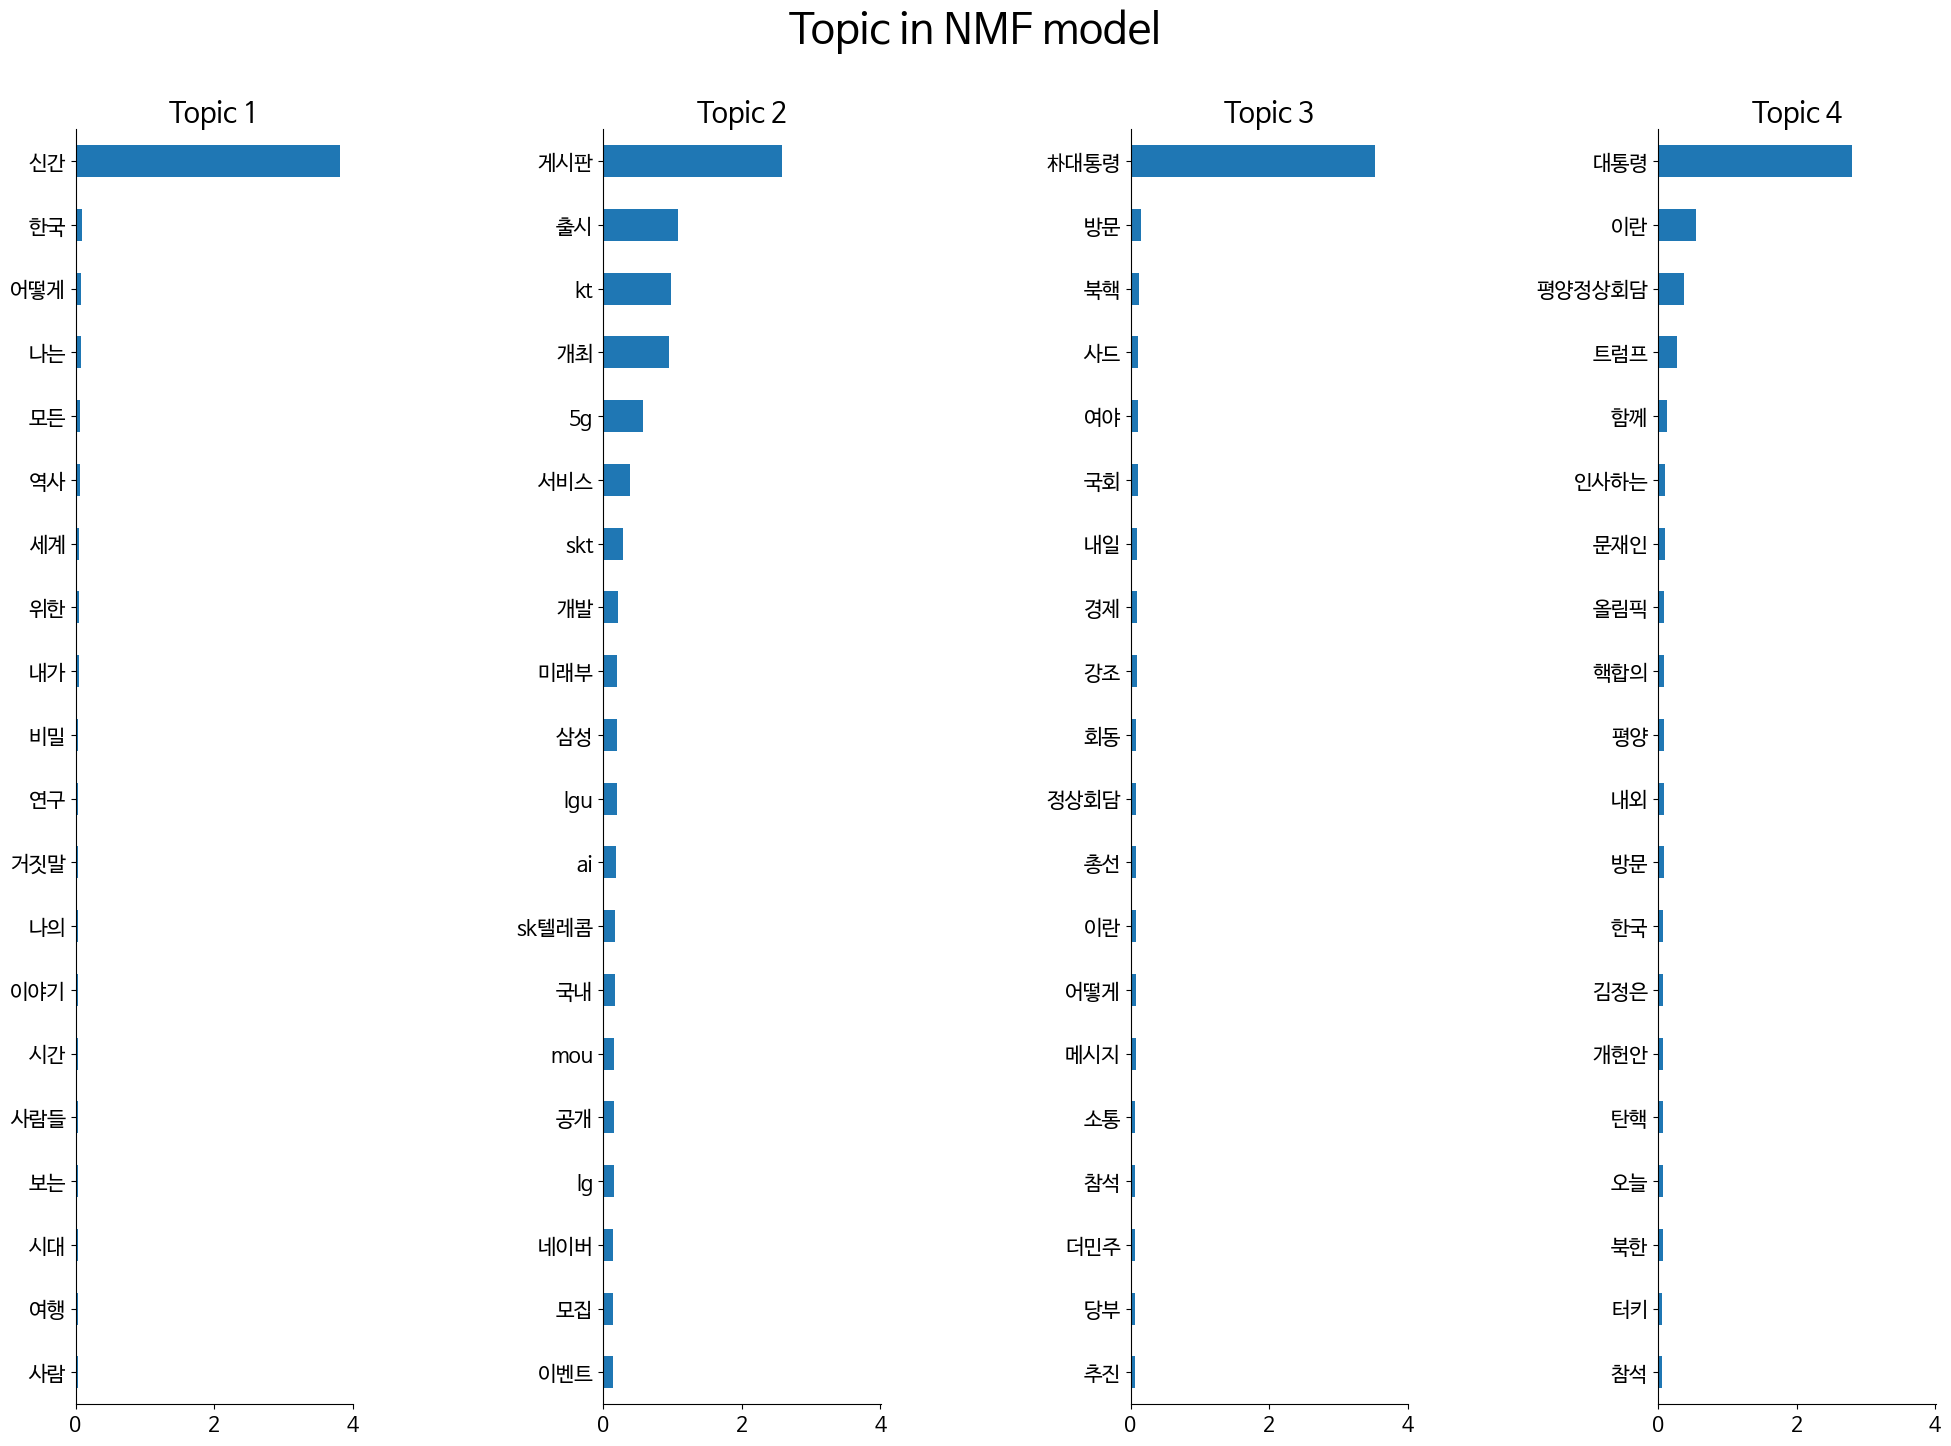

In [37]:
# NMF 토픽모델링 차트
# 모델링 마다 차트가 다른걸 알수가있다

plot_top_words(nmf_model,tfidfvect.get_feature_names_out(), n_top_words, 'Topic in NMF model')

### 토픽별 워드 클라우드

In [47]:
from wordcloud import WordCloud

font_path = r'/Library/Fonts/NanumGothic.ttf'

def draw_wordclouds(topic_words, topic_idx, font_path=font_path):
  wordcloud = WordCloud(width=800, height=400,
                        background_color='white',
                        font_path=font_path
                        ).generate_from_frequencies(topic_words)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(f'Topic {topic_idx + 1}', fontsize=20)
  plt.axis("off")
  plt.show()

In [41]:
df_nmf_h = pd.DataFrame(nmf_model.components_, columns=tfidfvect.get_feature_names_out())
df_nmf_h.head()

,00,01,02,03,0원,10,100,1004,100gb,100개,...,히어로즈,힐러리,힐러리트럼프,힐링,힐만,힘든,힘으로,힘은,힘찬,女배구
0,0.000107,0.000137,0.000035,0.000279,0.000000,0.000182,0.000076,0.000000,4.745383e-07,0.000017,...,0.000006,0.000220,5.143342e-07,0.000126,0.000110,0.000011,0.004447,0.000061,0.000030,0.000116
1,0.000619,0.002524,0.000257,0.000835,0.001485,0.022340,0.008298,0.002550,2.962397e-03,0.000602,...,0.001949,0.002578,2.388725e-04,0.000606,0.002186,0.000842,0.000753,0.000220,0.000136,0.001379
2,0.000209,0.000202,0.000128,0.000195,0.000030,0.002347,0.000614,0.000012,0.000000e+00,0.000229,...,0.000220,0.002329,3.263572e-04,0.000218,0.000789,0.000142,0.000150,0.000082,0.000000,0.000908
3,0.000547,0.000657,0.000284,0.000699,0.000080,0.011090,0.001515,0.000035,0.000000e+00,0.000287,...,0.000467,0.048025,4.775194e-04,0.000221,0.001635,0.000404,0.000218,0.000156,0.006483,0.002527


In [43]:
df_nmf_h.loc[0].to_dict()

{'00': 0.00010701977585680407,
 '01': 0.00013707662971746827,
 '02': 3.490581347746505e-05,
 '03': 0.00027919315553401466,
 '0원': 0.0,
 '10': 0.00018200505557406513,
 '100': 7.648918977567818e-05,
 '1004': 0.0,
 '100gb': 4.745383318984346e-07,
 '100개': 1.7044671738492563e-05,
 '100년': 0.008261696787226646,
 '100년전': 3.542565075556157e-05,
 '100대': 7.318148327532636e-05,
 '100만': 1.0046723291847614e-05,
 '100만대': 0.0,
 '100만명': 0.0,
 '100만원': 9.750359662047932e-05,
 '100명': 2.575964753964734e-05,
 '100배': 6.728203961715663e-06,
 '100번째': 2.63472184634094e-05,
 '100세시대': 0.0,
 '100억원': 0.0,
 '100여명': 1.2666474825376004e-05,
 '100원': 0.0,
 '100일': 0.0,
 '100조원': 0.0,
 '100주년': 0.00015964186761026865,
 '10개': 7.794552225879722e-05,
 '10곳': 6.899361397176702e-06,
 '10기가': 4.968853040673702e-05,
 '10년': 0.0018463120680265877,
 '10년간': 1.9109334336999356e-05,
 '10년만에': 9.918666387977951e-05,
 '10대': 0.0001811595522926766,
 '10도': 3.438138344623978e-05,
 '10만': 1.1722048435389235e-05,
 '10만개':

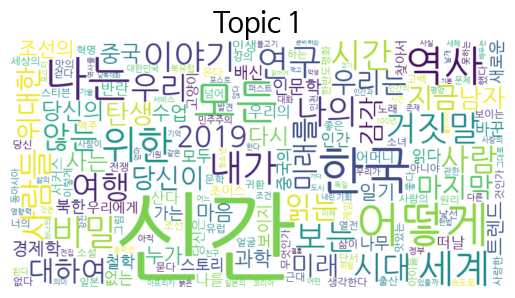

In [44]:
draw_wordclouds(df_nmf_h.loc[0].to_dict(),0)

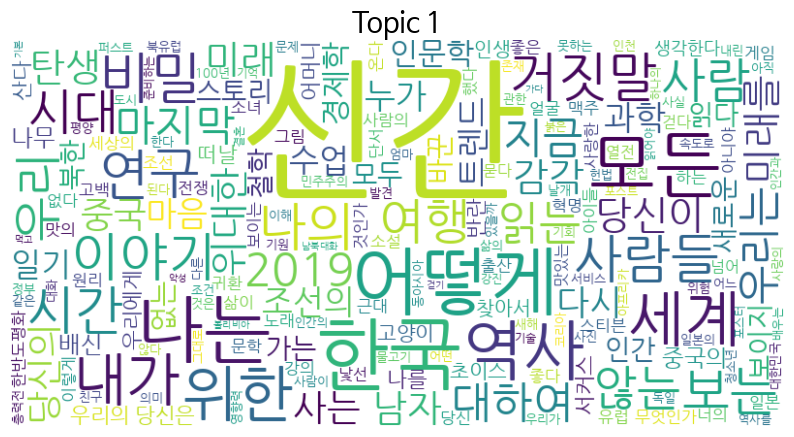

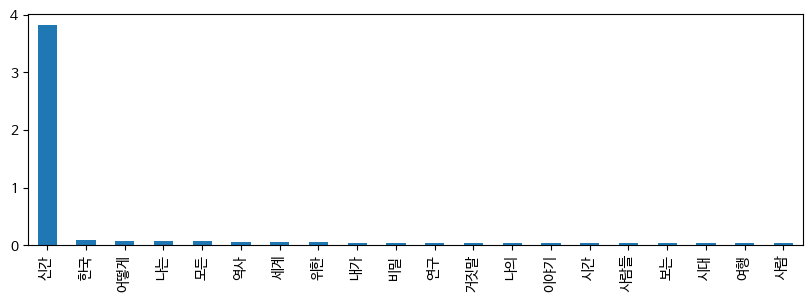

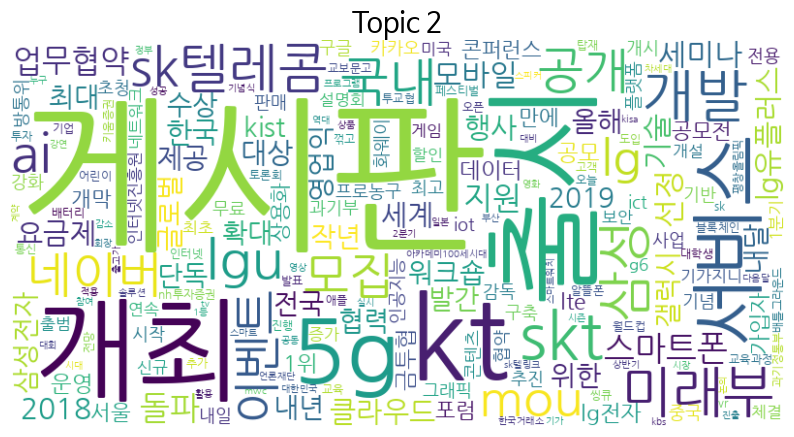

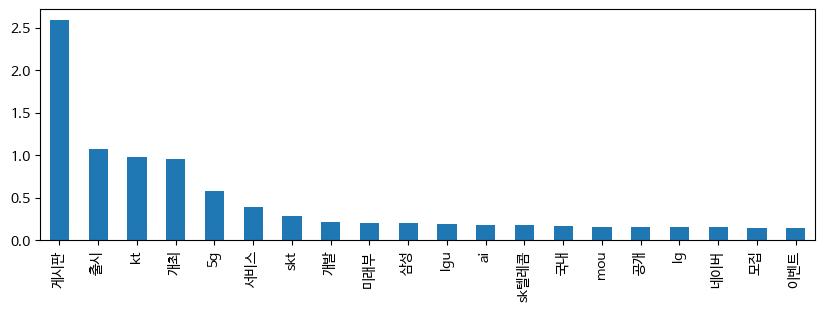

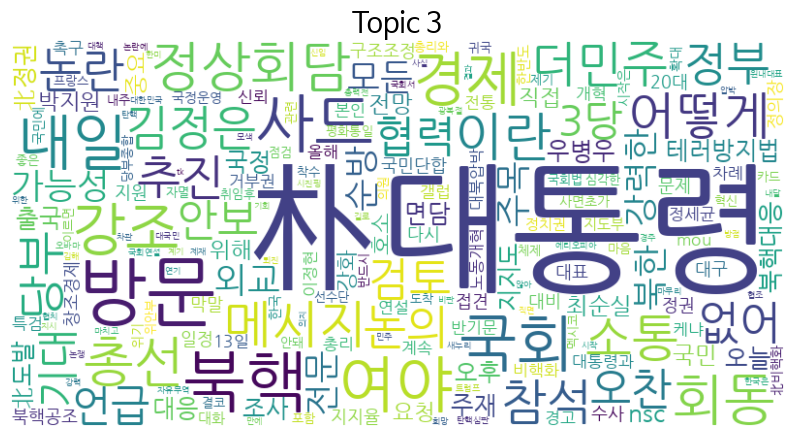

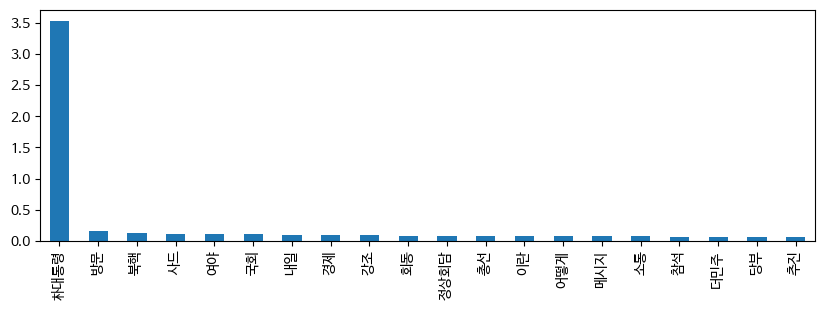

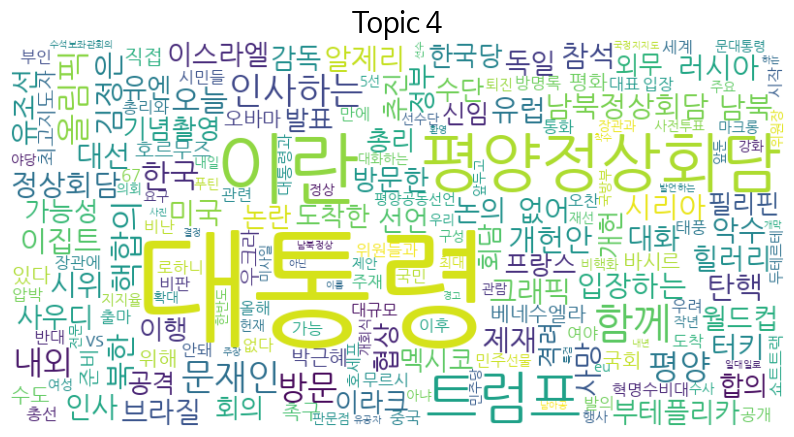

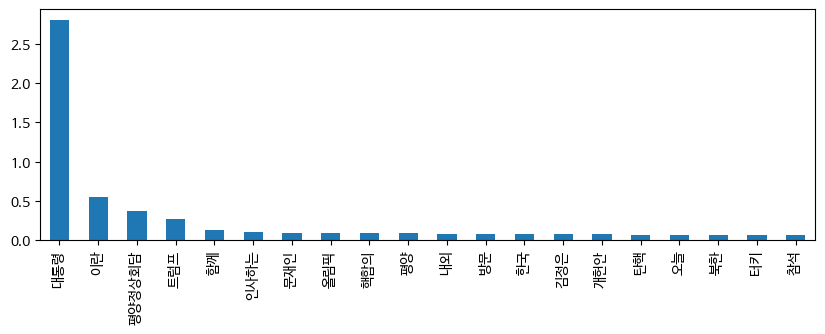

In [48]:
for topic_idx in range(n_components):
  draw_wordclouds(df_nmf_h.loc[topic_idx].to_dict(),topic_idx)
  df_nmf_h.loc[topic_idx].nlargest(20).plot(kind='bar',figsize=(10,3))